<a href="https://colab.research.google.com/github/anonymous3141/L65Project/blob/debug/model_behaviour_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plotting model behaviour: Norms, entropies, and losses

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import wandb
import seaborn as sns

sns.set_theme(style="darkgrid")

## Get data from Wandb


In [3]:
## Get data from Wandb
def get_runs(entity="jccamml", project="L65-project", algorithm="find_maximum_subarray_kadane"):
    api = wandb.Api(timeout=30)
    wandb_filters = {
        #"config.algorithms": [algorithm],
        "created_at": {"$gt": "2025-03-22T01"}, # greater than
        #"state": "finished",
    }
    runs = api.runs(f"{entity}/{project}", filters=wandb_filters)
    print(f"Found {len(runs)} runs.")
    data = {}
    for run in runs:
        if run.config['algorithms'] != [algorithm] or run.summary.get('_step',0) < 80000 or run.config['eval_every'] != 500:
            print(f"Skipping run {run.id} with algorithm {run.config['algorithms']} and steps {run.summary.get('_step',0)}")
            continue

        if data.get((run.config['processor_type'], run.config['hint_teacher_forcing'], run.config['seed'])) is None:
            data[(run.config['processor_type'], run.config['hint_teacher_forcing'], run.config['seed'])]  = run

    return data
data_kadane = get_runs()
data_insertion = get_runs("biermann-carla-university-of-cambridge","L65-project", "insertion_sort")

print(f"Length Kadane {len(data_kadane)}")
print(f"Length Insertion {len(data_insertion)}")
for c in sorted(data_kadane.keys()):
    print(c)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: biermann-carla (biermann-carla-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Found 230 runs.
Skipping run mf2en0ra with algorithm ['bfs'] and steps 0
Skipping run f8aowemb with algorithm ['bfs'] and steps 1181
Skipping run wskeew1n with algorithm ['bfs'] and steps 0
Skipping run ah31c565 with algorithm ['bfs'] and steps 0
Skipping run nbxcff2v with algorithm ['bfs'] and steps 0
Skipping run wyl28e32 with algorithm ['bfs'] and steps 0
Skipping run c40nf94c with algorithm ['bfs'] and steps 0
Skipping run r0tdmrsk with algorithm ['bfs'] and steps 0
Skipping run l4hssvng with algorithm ['bfs'] and steps 2
Skipping run qv2dvuaj with algorithm ['bfs'] and steps 3
Skipping run 140lw5y2 with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run 6q5qu1tn with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run 7o8sf2j5 with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run chz6czcc with algorithm ['find_maximum_subarray_kadane'] and steps 0
Skipping run drsfg7y7 with algorithm ['find_maximum_subarray_kadane'] and steps 0
S

In [4]:
processor_label_dict = {
    "mpnn": "MPNN",
    "differential_mpnn_msgdiff": "MSGD-MPNN",
    "differential_mpnn_maxmax": "MMD-MPNN",
    "differential_mpnn_maxmax-ablate_outer": "Ablation 1 (standard readout)",
    "differential_mpnn_maxmax-ablate_subtract": "Ablation 2 (no subtraction)"
}

color_map = {processor: plt.cm.tab10(i) for i, processor in enumerate(processor_label_dict)}

## Define Plotting Functions

In [7]:
def apply_ema(data, alpha=0.1):
    """Applies Exponential Moving Average smoothing to a 1D array."""
    ema = [data[0]]
    for n in range(1, len(data)):
        ema.append(alpha * data[n] + (1 - alpha) * ema[-1])
    return np.array(ema)

def plot_aggregated_metrics(data_dict, metric, title, ylabel, ax, color_map, ema_alpha=None):
    """
    Plots the mean and 95% confidence interval of a given metric over _step, aggregated by processor type,
    on the given axis, with optional EMA smoothing.

    Parameters:
    data_dict (dict): Dictionary where keys are tuples (processor_type, hint_tf, seed)
                      and values are DataFrames with columns '_step' and the specified metric.
    metric (str): The specific metric to plot (e.g., 'metric_name').
    title (str): The title to be used for the plot.
    ylabel (str): The label for the y-axis.
    ax (matplotlib axis): Axis on which to plot.
    color_map (dict): A dictionary that maps processor types to specific colors.
    ema_alpha (float, optional): The smoothing factor for EMA (0 < alpha <= 1).
                                  If None, EMA is not applied. Defaults to None.
    """
    # Aggregate data by processor type
    aggregated_data = {}
    for (processor_type, teacher_forcing, _), df in data_dict.items():
        if teacher_forcing != 0 or processor_type == "differential_mpnn_maxmax-sum":
            continue
        if processor_type not in aggregated_data:
            aggregated_data[processor_type] = []
        aggregated_data[processor_type].append(df)

    # Define the custom legend order
    custom_order = list(processor_label_dict.values())  # Ensure it's a list of processor labels

    # Initialize a list to store the handles and labels for the legend
    handles = []
    labels = []

    for processor_type, dfs in aggregated_data.items():
        if processor_type not in processor_label_dict:
            continue  # Skip if processor type is not in the label dictionary

        # Align data by _step and compute mean/CI
        all_steps = sorted(set.union(*[set(df["_step"]) for df in dfs]))  # Union of all _step values
        interpolated_values = []

        for df in dfs:
            if metric in df.columns:
                interp_values = np.interp(all_steps, df["_step"], df[metric])  # Interpolate missing steps
                interpolated_values.append(interp_values)
            else:
                print(f"Warning: Metric '{metric}' not found in DataFrame for {processor_type}.")
                continue

        if not interpolated_values:
            continue

        interpolated_values = np.array(interpolated_values)
        mean_values = np.mean(interpolated_values, axis=0)
        std_err = stats.sem(interpolated_values, axis=0, ddof=1)  # Standard error
        ci = std_err * stats.t.ppf(0.975, len(interpolated_values) - 1)  # 95% confidence interval

        lower = mean_values - ci
        upper = mean_values + ci

        if ylabel == "Entropy":
            lower = np.maximum(lower, 0)
            upper = np.maximum(upper, 0)
            mean_values = np.maximum(mean_values, 0)

        # Apply EMA smoothing if alpha is provided
        if ema_alpha is not None:
            mean_values = apply_ema(mean_values, alpha=ema_alpha)
            lower = apply_ema(lower, alpha=ema_alpha)
            upper = apply_ema(upper, alpha=ema_alpha)

        # Plot mean and confidence interval with fixed color for each processor type
        color = color_map.get(processor_type, 'black')  # Default to 'black' if no color is found
        line, = ax.plot([step / 10000 for step in all_steps], mean_values, label=processor_label_dict[processor_type], color=color)
        ax.fill_between([step / 10000 for step in all_steps], lower, upper, color=color, alpha=0.3)

        # Collect the handles and labels for the legend
        handles.append(line)
        labels.append(processor_label_dict[processor_type])

    # Reorder the legend according to the custom order
    ordered_handles = []
    ordered_labels = []

    # Ensure that the legend is ordered as per custom_order
    for label in custom_order:
        if label in labels:
            index = labels.index(label)
            ordered_handles.append(handles[index])
            ordered_labels.append(labels[index])

    ax.set_title(title)
    ax.set_xlabel("Training Step (×$10^4$)")
    ax.set_ylabel(ylabel)
    ax.legend(handles=ordered_handles, labels=ordered_labels)

def plot_all_metrics_together(data_dict_1, data_dict_2, metrics_1, metrics_2, titles_1, titles_2, ylabel, filename="combined_plots.pdf", num_cols=2, ema_alpha=None):
    """
    Plots a specified list of metrics for two algorithms in a single figure, saving it to a PDF,
    with an option to apply EMA smoothing.

    Parameters:
    data_dict_1 (dict): Data dictionary for the first algorithm (e.g., Insertion Sort).
    data_dict_2 (dict): Data dictionary for the second algorithm (e.g., Kadane).
    metrics_1 (list): A list of metric names to plot for the first algorithm.
    metrics_2 (list): A list of metric names to plot for the second algorithm.
    titles_1 (list): A list of titles corresponding to the metrics in metrics_1.
    titles_2 (list): A list of titles corresponding to the metrics in metrics_2.
    ylabel (str): The label for the y-axis (applied to all plots).
    filename (str): The filename to save the plot as.
    num_cols (int): The number of columns in the subplot grid.
    ema_alpha (float, optional): The smoothing factor for EMA (0 < alpha <= 1).
                                  If None, EMA is not applied. Defaults to None.
    """
    # Ensure the directory exists
    directory = os.path.dirname(filename)
    if directory and not os.path.exists(directory):
        os.makedirs(directory)

    num_metrics = len(metrics_1) + len(metrics_2)
    num_rows = (num_metrics + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5 * num_rows), sharex=True)
    axes = np.ravel(axes)  # Flatten the axes array for easy indexing

    plot_index = 0
    for (metric, title) in zip(metrics_1, titles_1):
        # Plot for the first algorithm
        if plot_index < len(axes):
            plot_aggregated_metrics(data_dict_1, metric, title, ylabel,
                                    axes[plot_index], color_map, ema_alpha)
            plot_index += 1

    for (metric, title) in zip(metrics_2, titles_2):
        # Plot for the second algorithm
        if plot_index < len(axes):
            plot_aggregated_metrics(data_dict_2, metric, title, ylabel,
                                    axes[plot_index], color_map, ema_alpha)
            plot_index += 1

    # Remove any unused subplots
    if plot_index < len(axes):
        for i in range(plot_index, len(axes)):
            fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    fig.savefig(filename)
    plt.close(fig)

## Norms

In [6]:
# {algorithm}_test_aggregated_msg_combined_avg_norm
# {algorithm}_test_aggregated_msg_postdiff_avg_norm

def get_history_data_test(runs, keys):
    cache = {}
    for (name, run) in runs.items():
        history_data = run.history(keys=keys)
        history_data = history_data[(history_data["_step"] <= 80000) & (history_data["_step"] % 500 == 0)]  # Keep only <= 80k steps
        cache[name] = history_data
    return cache

algorithm = "insertion_sort"
keys_insertion = [f"{algorithm}_test_aggregated_msg_postdiff_avg_norm", f"{algorithm}_test_aggregated_msg_combined_avg_norm"]
cache_norms_insertion = get_history_data_test(data_insertion, keys_insertion)

algorithm = "find_maximum_subarray_kadane"
keys_kadane = [f"{algorithm}_test_aggregated_msg_postdiff_avg_norm", f"{algorithm}_test_aggregated_msg_combined_avg_norm"]
cache_norms_kadane = get_history_data_test(data_kadane, keys_kadane)

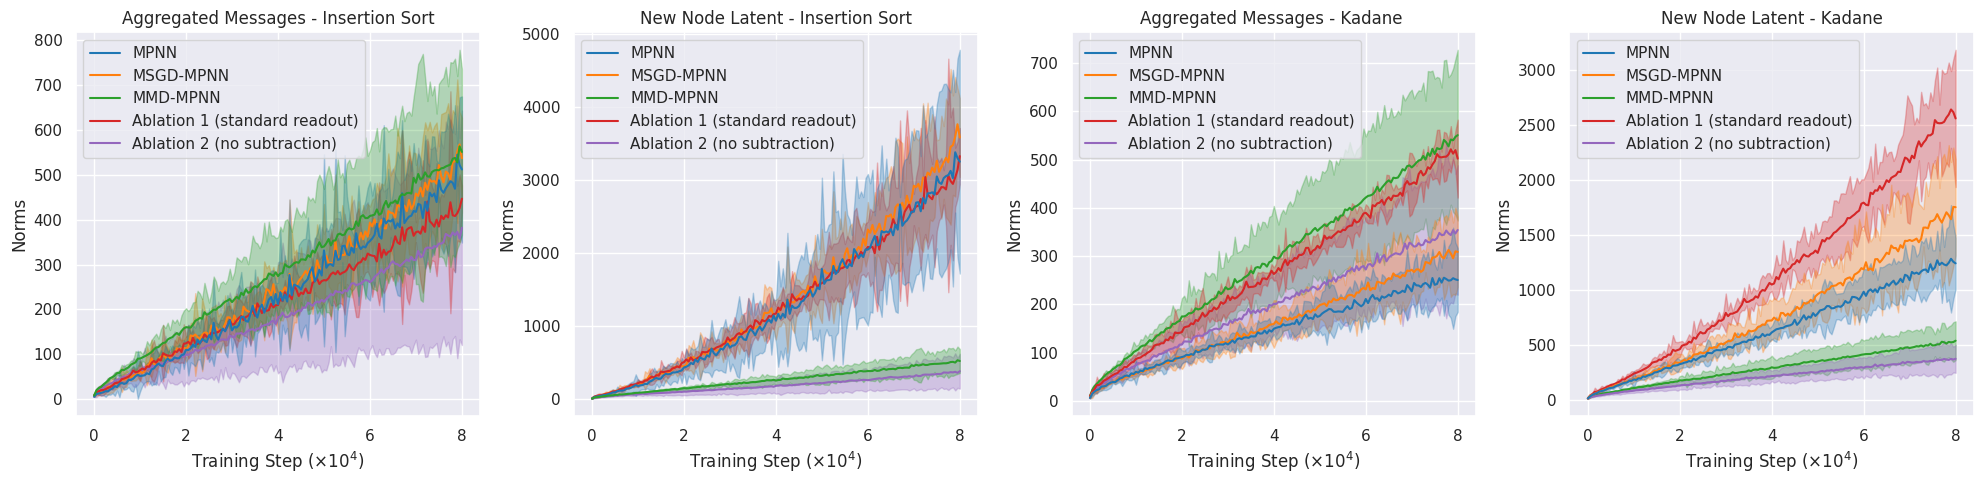

In [8]:
plot_all_metrics_together(
    cache_norms_insertion,
    cache_norms_kadane,
    keys_insertion,
    keys_kadane,
    ["Aggregated Messages - Insertion Sort", "New Node Latent - Insertion Sort"],
    ["Aggregated Messages - Kadane ", "New Node Latent - Kadane"],
    "Norms",
    "losses_combined.pdf",
    num_cols=4,
)

## Entropies

In [9]:
## Entropies
def get_history_data(runs, keys):
    cache = {}
    for (name, run) in runs.items():
        history_data = run.history(keys=keys)
        history_data = history_data[(history_data["_step"] <= 80000)]  # Keep only <= 80k steps
        cache[name] = history_data
    return cache

algorithm = "insertion_sort"
hints_insertion = ["pred_h", "i", "j"]
keys_insertion = [f"{algorithm}_test_{h}_entropy" for h in hints_insertion]
cache_entropies_insertion = get_history_data(data_insertion, keys_insertion)

algorithm = "find_maximum_subarray_kadane"
hints_kadane = ["i", "j", "best_low", "best_high"]
keys_kadane = [f"{algorithm}_test_{h}_entropy" for h in hints_kadane]
cache_entropies_kadane = get_history_data(data_kadane, keys_kadane)


In [10]:
titles_insertion = [
    #"Insertion Sort Hint pred_h Entropy - Val",
    #"Insertion Sort Hint i Entropy - Val",
    #"Insertion Sort Hint j Entropy - Val",
    "Insertion Sort Hint pred_h Entropy - Test",
    "Insertion Sort Hint i Entropy - Test",
    "Insertion Sort Hint j Entropy - Test"
]
titles_kadane = [
    #"Kadane Hint i Entropy - Val",
    #"Kadane Hint j Entropy - Val",
    #"Kadane Hint best_low Entropy - Val",
    #"Kadane Hint best_high Entropy - Val",
    "Kadane Hint i Entropy - Test",
    "Kadane Hint j Entropy - Test",
    "Kadane Hint best_low Entropy - Test",
    "Kadane Hint best_high Entropy - Test",
]

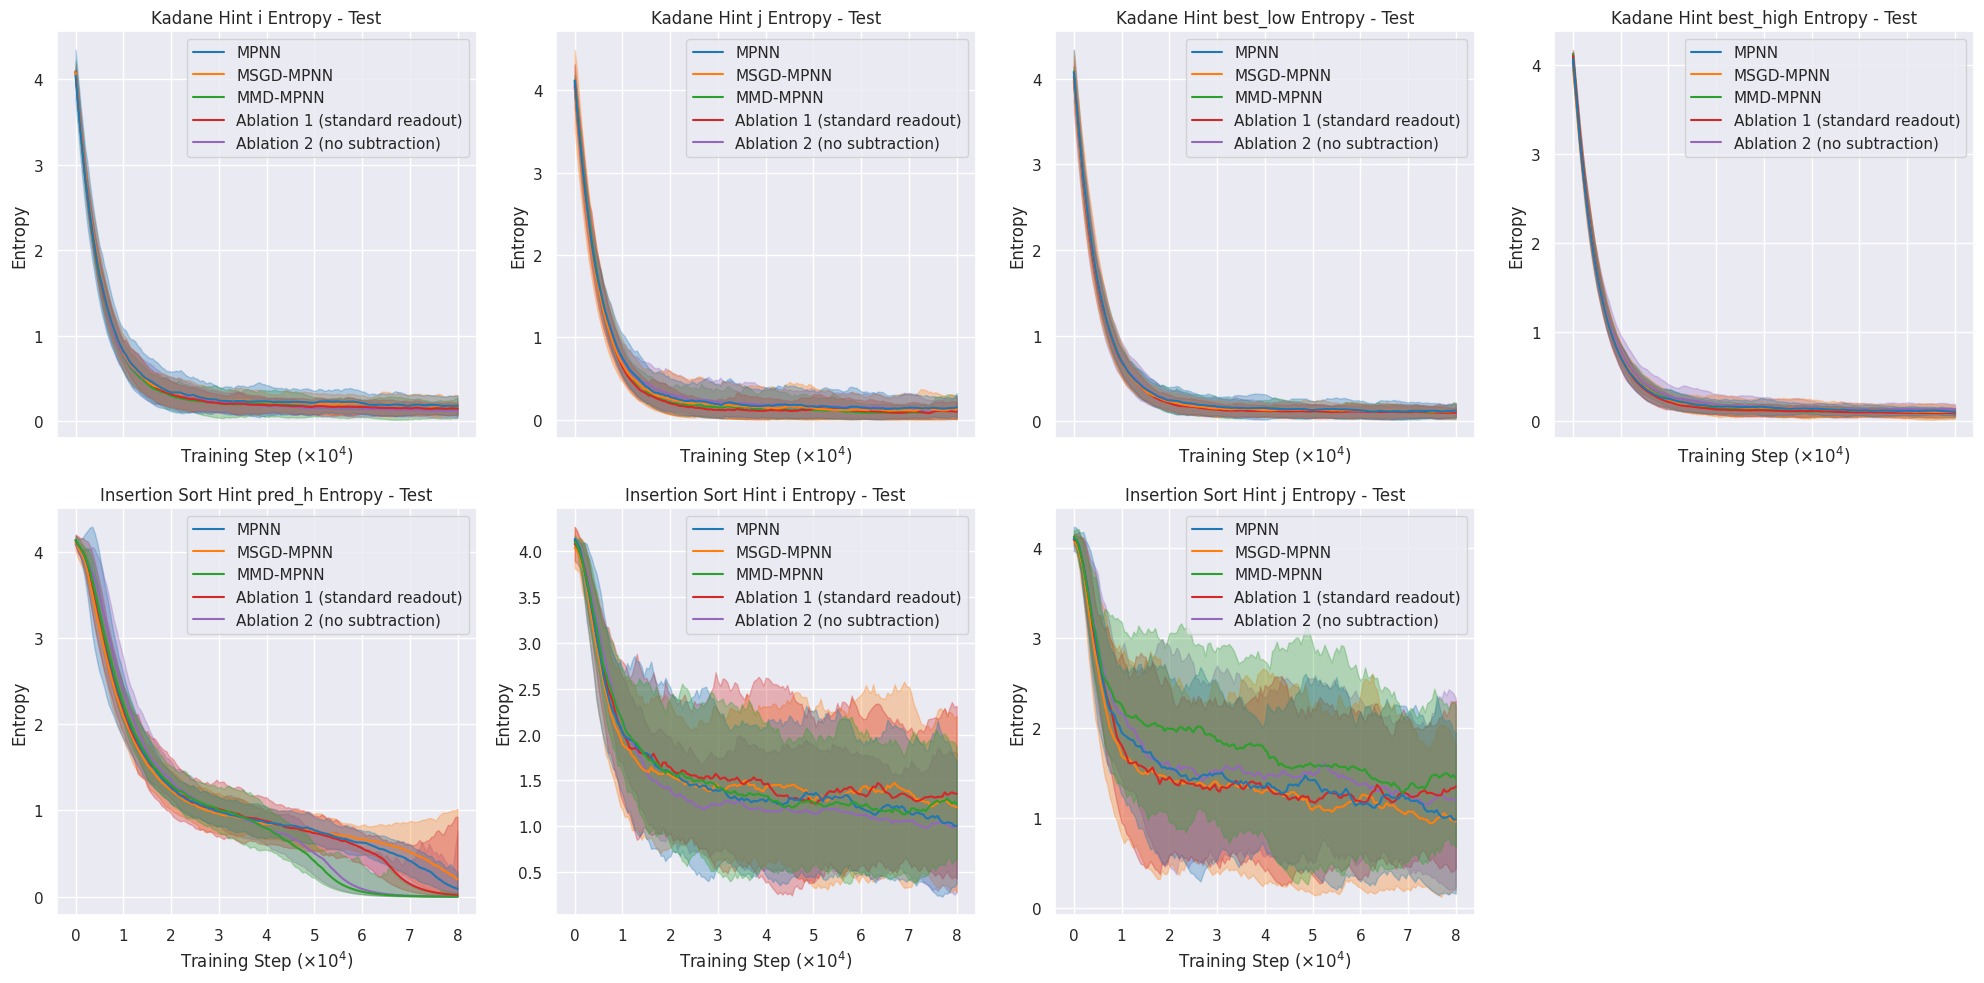

In [11]:
plot_all_metrics_together(
    cache_entropies_kadane,
    cache_entropies_insertion,
    keys_kadane,
    keys_insertion,
    titles_kadane,
    titles_insertion,
    "Entropy",
    "entropies_combined.pdf",
    num_cols=4,
    ema_alpha=0.1
)

## Losses

In [12]:
def get_history_data_losses(runs, keys_hints, keys_output):
    cache = {}
    all_keys = keys_hints + keys_output
    for (name, run) in runs.items():
        history_data = run.history(keys=all_keys)
        history_data = history_data[(history_data["_step"] <= 80000)]  # Keep only <= 80k steps
        history_data["hints_loss"] = history_data[keys_hints].sum(axis=1)
        cache[name] = history_data
    return cache

algorithm = "insertion_sort"
hints_insertion = ["pred_h", "i", "j"]
keys_insertion_hints = [f"{algorithm}_loss_truth_{h}" for h in hints_insertion]
keys_insertion_output = [f"{algorithm}_output_loss"]
cache_losses_insertion = get_history_data_losses(data_insertion, keys_insertion_hints, keys_insertion_output)

algorithm = "find_maximum_subarray_kadane"
hints_kadane = ["i", "j", "best_low", "best_high", "sum", "best_sum"]
keys_kadane_hints = [f"{algorithm}_loss_truth_{h}" for h in hints_kadane]
keys_kadane_output = [f"{algorithm}_output_loss"]
cache_losses_kadane = get_history_data_losses(data_kadane, keys_kadane_hints, keys_kadane_output)

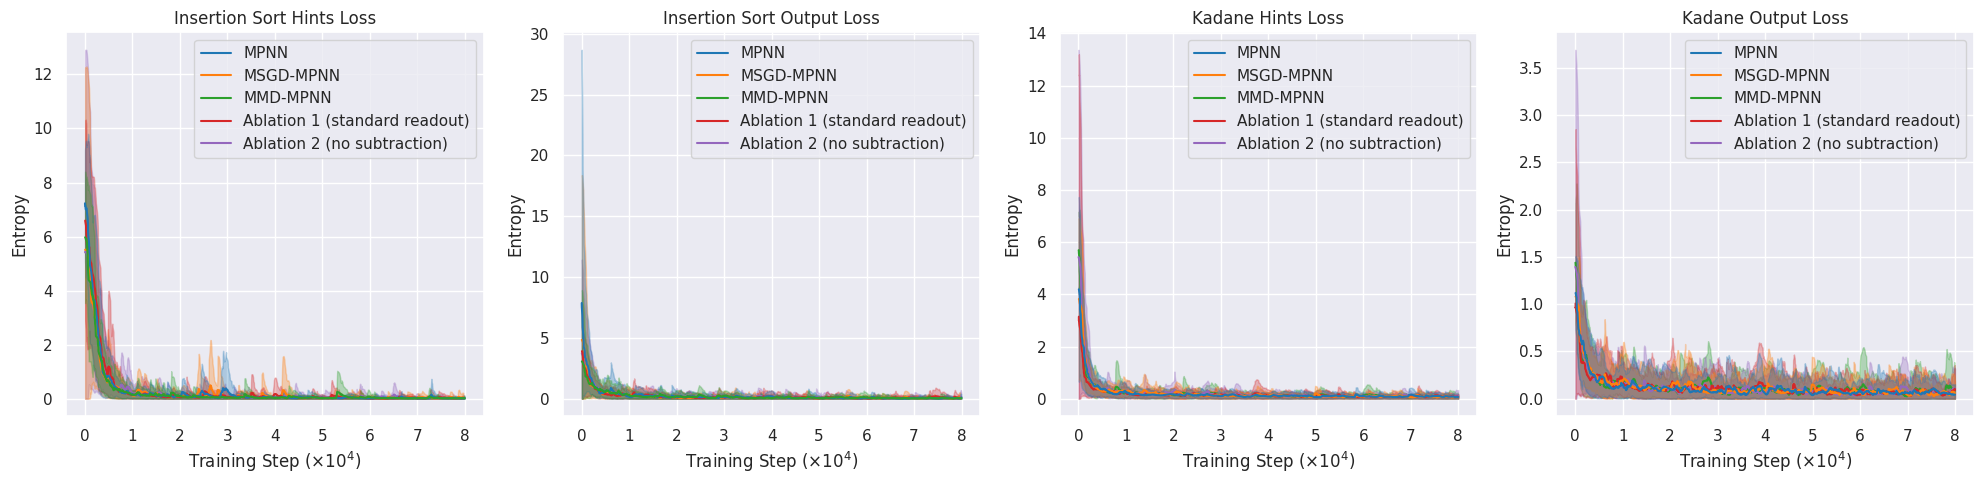

In [13]:
plot_all_metrics_together(
    cache_losses_insertion,
    cache_losses_kadane,
    ["hints_loss", "insertion_sort_output_loss"],
    ["hints_loss", "find_maximum_subarray_kadane_output_loss"],
    ["Insertion Sort Hints Loss", "Insertion Sort Output Loss"],
    ["Kadane Hints Loss", "Kadane Output Loss"],
    "Entropy",
    "losses_combined.pdf",
    num_cols=4,
    ema_alpha=0.1
)

## Previous (from other notebook): Hints

In [ ]:
data_dir = "hint_outputs"

def parse_filename_insertion_sort(filename):
    parts = filename.replace(".npz", "").split("_")
    algorithm = "_".join(parts[0:2])
    seed = int(parts[2])
    processor_type = "_".join(parts[3:-1])  # Everything between seed and hint_teacher_forcing
    hint_teacher_forcing = float(parts[-1])

    return algorithm, seed, processor_type, hint_teacher_forcing

def parse_filename_kadane(filename):
    parts = filename.replace(".npz", "").split("_")
    algorithm = "_".join(parts[0:4])
    seed = int(parts[4])
    processor_type = "_".join(parts[5:-1])  # Everything between seed and hint_teacher_forcing
    hint_teacher_forcing = float(parts[-1])

    return algorithm, seed, processor_type, hint_teacher_forcing

def read_files_into_df(algorithm, data_dir, parsefn, hints):
    records = []

    # Read all npz files and extract data
    for file in os.listdir(data_dir):
        if file.endswith(".npz") and file.startswith(algorithm):  # Ensure we're only reading NPZ files
            algorithm, seed, processor_type, hint_teacher_forcing = parsefn(file)

            file_path = os.path.join(data_dir, file)
            npz_data = np.load(file_path)

            record = {
                "algorithm": algorithm,
                "seed": seed,
                "processor_type": processor_type,
                "hint_teacher_forcing": hint_teacher_forcing
            }

            for hint in hints:
                record[hint] = list(npz_data[hint])

            records.append(record)

    # Create DataFrame
    df = pd.DataFrame(records)

    return df

# Function to compute mean and 95% confidence intervals
def compute_stats(arrays):
    arrays = np.vstack(arrays)  # Stack into a 2D array (seeds × time_steps)
    mean = np.mean(arrays, axis=0)
    std_err = stats.sem(arrays, axis=0, ddof=1)  # Standard error
    ci = std_err * stats.t.ppf(0.975, len(arrays) - 1)  # 95% confidence interval
    return mean, ci
hints_kadane = ["i_along_time", "j_along_time", "best_sum_along_time", "sum_along_time", "best_low_along_time", "best_high_along_time"]
df_kadane = read_files_into_df("find_maximum_subarray_kadane", data_dir, parse_filename_kadane, hints_kadane)

df_kadane = df_kadane[df_kadane["seed"] != 42]

# Display first few rows
print(df_kadane.head())

hints_insertion = ["i_along_time", "j_along_time"]
df_insertion = read_files_into_df("insertion_sort", data_dir, parse_filename_insertion_sort, hints_insertion)

# Display first few rows
print(df_insertion.head())

df_insertion = df_insertion[df_insertion["processor_type"].isin(["mpnn", "differential_mpnn_maxmax"])]
df_insertion = df_insertion[df_insertion["hint_teacher_forcing"] == 0.0]
processor_label_dict = {
    "mpnn": "MPNN",
    "differential_mpnn_msgdiff": "MSGD-MPNN",
    "differential_mpnn_maxmax": "MMD-MPNN",
    "differential_mpnn_maxmax-ablate_outer": "Ablation 1 (standard readout)",
    "differential_mpnn_maxmax-ablate_subtract": "Ablation 2 (no subtraction)"
}

color_map = {processor: plt.cm.tab10(i) for i, processor in enumerate(processor_label_dict)}

def plot_hints(df, algo_title, hints, color_map, ncols=2):
    """
    Plots the mean and 95% confidence interval for different hints in a dataframe grouped by processor type
    and hint teacher forcing. The plots are arranged in subplots with two columns.

    Parameters:
    df (DataFrame): The input dataframe containing columns 'processor_type', 'hint_teacher_forcing', and hint values.
    hints (list of str): List of hints (column names) to plot.
    ncols (int): Number of columns for subplots (default is 2).
    """
    grouped = df.groupby(["processor_type", "hint_teacher_forcing"])
    num_hints = len(hints)
    nrows = (num_hints + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows), sharex=True)
    axes = np.array(axes).reshape(nrows, ncols)  # Ensure axes is always a 2D array

    for idx, hint in enumerate(hints):
        row, col = divmod(idx, ncols)
        ax = axes[row, col]

        for model_idx, ((processor, hint_tf), group) in enumerate(grouped):
            arrays = np.stack(group[hint].to_numpy())  # Convert column to numpy array
            mean = np.mean(arrays, axis=0)
            std_err = stats.sem(arrays, axis=0, ddof=1)  # Standard error
            ci = std_err * stats.t.ppf(0.975, len(arrays) - 1)  # 95% confidence interval

            lower_bound = mean - ci
            upper_bound = mean + ci

            # Cap CI at y=1 if not in specific hints
            if hint not in ["sum_along_time", "best_sum_along_time"]:
                upper_bound = np.minimum(upper_bound, 1)

            color = color_map[processor] # Assign unique color
            ax.plot(mean, label=f"{processor_label_dict[processor]}", color=color)
            ax.fill_between(range(len(mean)), lower_bound, upper_bound, alpha=0.3, color=color)

        ylabel = "Mean square error" if hint in ["sum_along_time", "best_sum_along_time"] else "Accuracy"
        hint_str = hint.removesuffix("_along_time")
        ax.set_ylabel(ylabel)
        ax.set_xlabel("Intermediate Trajectory Steps")
        ax.set_title(f"{algo_title} Hint {hint_str}")
        ax.legend()

    # Hide any unused subplots
    for idx in range(num_hints, nrows * ncols):
        fig.delaxes(axes.flatten()[idx])

    fig.suptitle("MMD-MPNN vs MPNN hint predictions")
    plt.tight_layout()
    #fig.savefig(f"{algorithm}_hint_analysis.pdf", dpi=300)
    plt.show()


plot_hints(df_insertion, "Insertion Sort", ["i_along_time", "j_along_time"], color_map)
plot_hints(df_kadane, "Kadane", hints_kadane, color_map)
